<a href="https://colab.research.google.com/github/Artur4ik2304/Yandex_ML_3.0/blob/main/hw_05/hw_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import xgboost as xgb

In [4]:
data = pd.read_csv('train.csv')
data.head()

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,75516,1731.4840,411.7352,245.7620,0.8023,310.0806,0.9148,82546,0.7169,1.6753,0.3165,0.7531,0.0055,0.0033,0.5672,0.9502,1
1,98903,1374.4370,477.2451,269.7676,0.8249,354.8622,0.9585,103181,0.7679,1.7691,0.6579,0.7436,0.0048,0.0027,0.5529,0.9781,0
2,84746,1311.1570,482.7735,235.9040,0.8725,328.4843,0.9121,92914,0.7162,2.0465,0.6195,0.6804,0.0057,0.0028,0.4630,0.9474,1
3,98184,1463.1680,434.3769,292.6472,0.7390,353.5700,0.9543,102890,0.7316,1.4843,0.5763,0.8140,0.0044,0.0030,0.6625,0.9834,0
4,94170,1267.7271,440.1109,278.4162,0.7745,346.2672,0.9643,97656,0.6836,1.5808,0.7363,0.7868,0.0047,0.0030,0.6190,0.9785,0


In [5]:
data.isnull().sum()

,0
area,0
perimeter,0
major_axis,0
minor_axis,0
eccentricity,0
eqdiasq,0
solidity,0
convex_area,0
extent,0
aspect_ratio,0


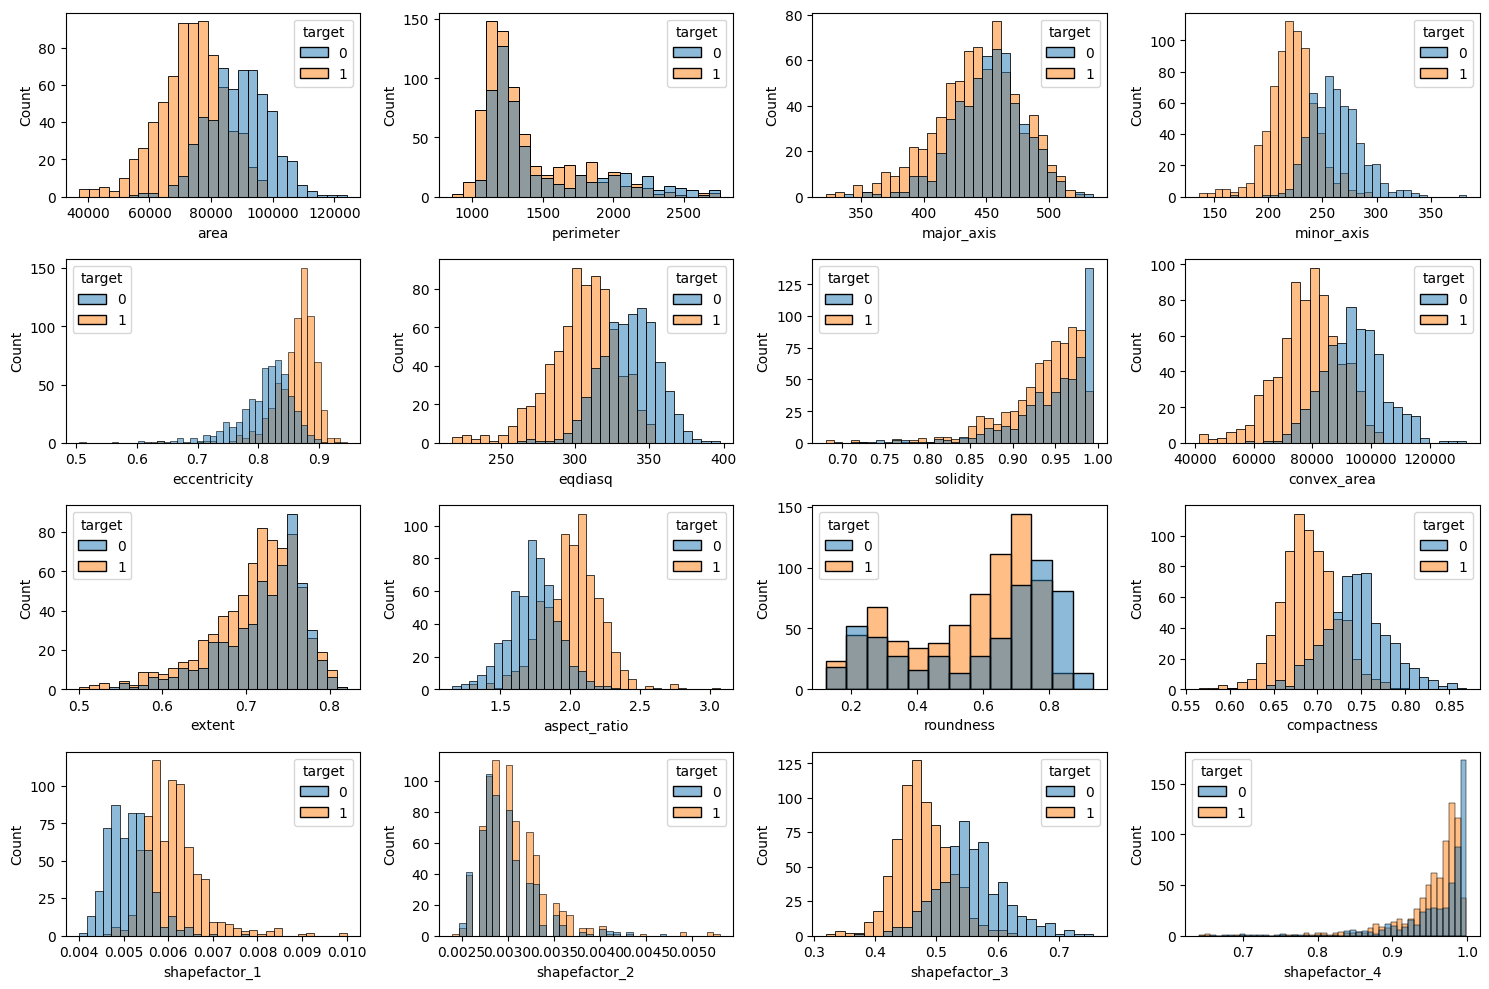

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10))

row, col = 0, 0
for name in data.columns:
  sns.histplot(data=data, x=name, ax=axes[row, col], hue='target')
  if col == 3 and row == 3:
    break
  if col == 3:
    col = 0
    row += 1
  else:
      col += 1

plt.tight_layout()

<Axes: xlabel='aspect_ratio', ylabel='eccentricity'>

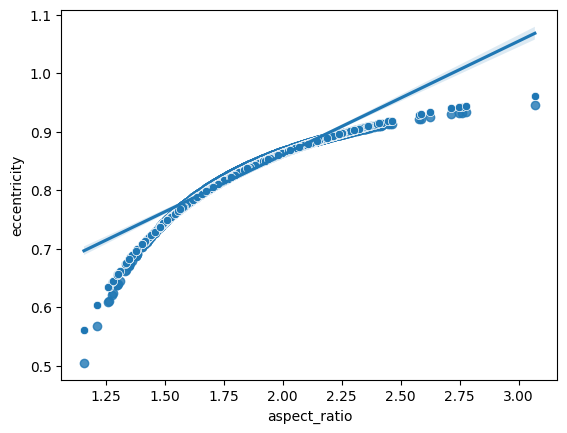

In [78]:
sns.regplot(data=data, x='aspect_ratio', y='eccentricity');
sns.scatterplot(x=data['aspect_ratio'], y=-0.355/(data['aspect_ratio'] - 0.5) + 1.1)

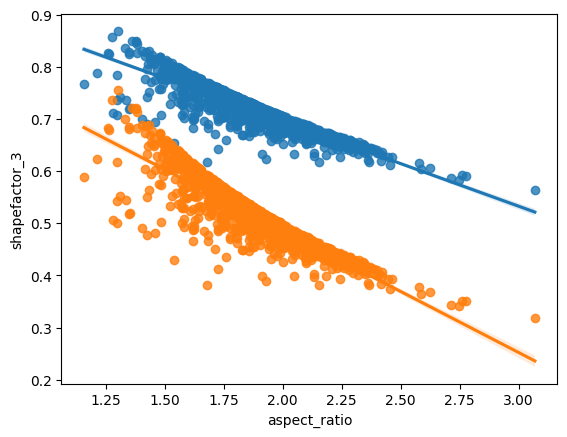

In [110]:
sns.regplot(data=data, x='aspect_ratio', y='compactness');
sns.regplot(data=data, x='aspect_ratio', y='shapefactor_3');

<Axes: xlabel='compactness', ylabel='shapefactor_3'>

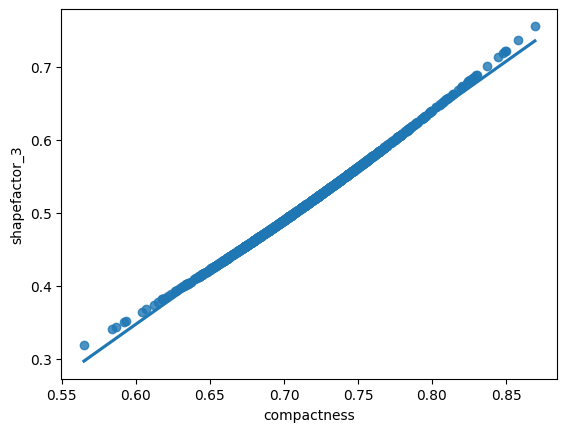

In [106]:
sns.regplot(data=data, x='compactness', y='shapefactor_3')

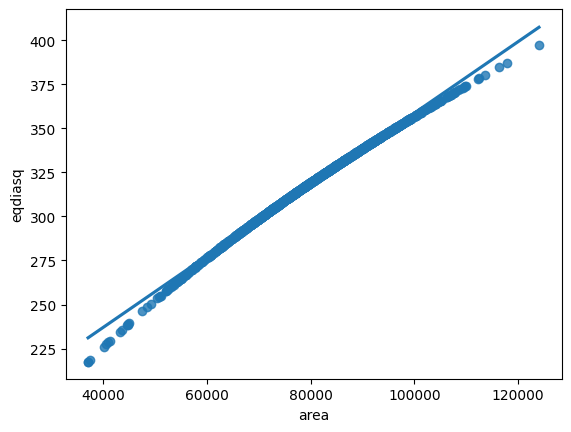

In [107]:
sns.regplot(data=data, x='area', y='eqdiasq');

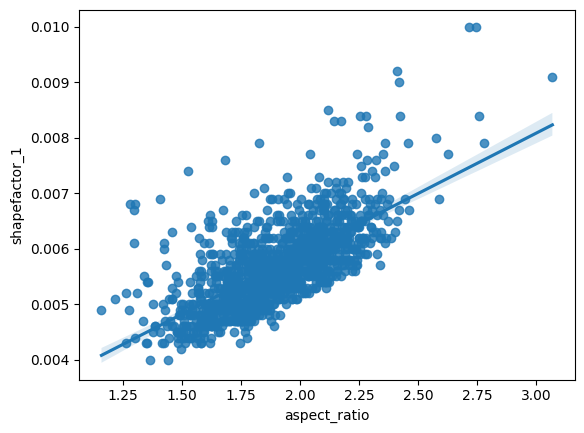

In [113]:
sns.regplot(data=data, x='aspect_ratio', y='shapefactor_1');

In [119]:
data_clear = data.copy()

In [120]:
for elem in ['shapefactor_4', 'eccentricity', 'solidity', 'shapefactor_1', 'shapefactor_2']:
    Q1 = data[name].quantile(0.25)
    Q3 = data[name].quantile(0.75)
    IQR = Q3 - Q1

    data_clear = data_clear[~(data_clear[name] < (Q1 - 1.5*IQR)) | (data_clear[name] > (Q3 + 1.5*IQR))]

In [124]:
data_clear = data_clear.drop(['compactness', 'eqdiasq'], axis=1)

In [255]:
X_train, X_test, y_train, y_test = train_test_split(data_clear.drop('target', axis=1).values,
                                                    data_clear['target'].values,
                                                    shuffle=True, random_state=42, stratify=data_clear['target'])

In [256]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [494]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [377]:
# Evaluate function, that returns main metrics
def evaluate(y_true, y_pred, y_pred_proba=[]):
    if len(y_pred_proba) != 0:
        print(f'accuracy: {accuracy_score(y_true, y_pred)} \
        \nprecision: {precision_score(y_true, y_pred)} \
        \nrecall: {recall_score(y_true, y_pred)} \
        \nroc-auc: {roc_auc_score(y_true, y_pred_proba)}')

In [378]:
params = {'n_estimators': range(2, 500, 50), 'max_depth': range(2, 20, 1), 'lambda': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]}
xg_grid = RandomizedSearchCV(xgb.XGBClassifier(), params, verbose=2, n_iter=20, n_jobs=-1)

In [379]:
xg_grid.fit(X_train_scale, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'lambda': [0.001, 0.01, 0.1, 1, 10.0,
                                                   100.0, 1000.0],
                                        'max_depth': range(2, 20),
                                        'n_estimators': range(2, 500, 50)},
                   verbose=2)

In [380]:
xg_clf = xg_grid.best_estimator_

In [381]:
y_pred, y_pred_proba = xg_clf.predict(X_test_scale), xg_clf.predict_proba(X_test_scale)[:, 1]
evaluate(y_test, y_pred, y_pred_proba)

accuracy: 0.8926174496644296         
precision: 0.9017341040462428         
recall: 0.9122807017543859         
roc-auc: 0.9502003039093797


In [382]:
X_train.shape

(892, 14)

In [507]:
# Преобразуем в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_scale, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Для CrossEntropyLoss

# Создаем Dataset и DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [508]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [542]:
class MyNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(14, 16)
    self.bn1 = nn.BatchNorm1d(16)
    self.fc2 = nn.Linear(16, 2)

  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = self.fc2(x)
    return x

model = MyNN().to(device)

In [551]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [555]:
total_step = len(train_data_loader)
loss_list = []
acc_list = []
for epoch in range(500):
    for i, (input, labels) in enumerate(train_data_loader):
        # Прямой запуск
        input = input.to(device)
        labels = labels.to(device)
        outputs = model(input)
        loss = loss_fn(outputs, labels)
        loss_list.append(loss.item())

        # Обратное распространение и оптимизатор
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Отслеживание точности
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, 5, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

In [556]:
# Преобразуем в тензоры PyTorch
X_test_tensor = torch.tensor(X_test_scale, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  # Для CrossEntropyLoss

# Создаем Dataset и DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [557]:
def evaluate(model, dataloader):
    model.eval()  # Режим оценки
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Пример использования
val_accuracy = evaluate(model, test_data_loader)  # Нужен val_loader
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 90.60%


In [559]:
data_val = pd.read_csv('test.csv')

In [560]:
X_val = data_val.drop(['compactness', 'eqdiasq'], axis=1).values
X_val_scale = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scale)

In [561]:
X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)

In [562]:
with torch.no_grad():
  X_val_tensor = X_val_tensor.to(device)
  output = model(X_val_tensor)

In [563]:
outp = output.cpu().numpy()

In [564]:
res = []
for elem in outp:
  res.append(int(np.argmax(elem)))

In [565]:
res = np.array(res)

In [566]:
np.savetxt('answers.csv', res, delimiter=',', fmt='%d')